# Import Packages and Libraries
---
First, we import the libraries that we are going to use, including libraries for dataset preparation, text preprocessing, vector manipulation, feature engineering and model training.

**Note:** All these libraries need to be downloaded beforehand.

In [ ]:
import numpy as np
import string
import os
import pandas as pd
import re
import random
import operator
import nltk
import warnings
warnings.filterwarnings('ignore')

# download and loade the stop words from nltk library
nltk.download('stopwords') 
stopwords=set(nltk.corpus.stopwords.words('english'))
stopwords.add("'s")
nltk.download('punkt') 
nltk.download('wordnet') 
nltk.download('averaged_perceptron_tagger')
lemmatizer = nltk.stem.WordNetLemmatizer()
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet

import sklearn
from sklearn.metrics import make_scorer,accuracy_score,precision_score,f1_score,recall_score
from sklearn.utils import shuffle
from sklearn.svm import SVC


from sklearn import model_selection, preprocessing, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


from textblob import TextBlob
#!pip install num2words
from num2words import num2words


from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectPercentile, chi2




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#Helper Function

###Dataset Loading and Transforming Function
---
This function will recive root path and csv path as parameters. then it will loade the BBC News articals dataset and transform it to Csv files and return dataframe of the dataset.



In [ ]:
def loading_and_transforming_dataset(root_path,csv_path):
    print("Loading The Dataset ...... Done \n")
    # walk through the root directory 
    for root,dirs,_ in os.walk(root_path):
       # open each directory inside the root path
       for name in dirs:
           path=os.path.join(root, name)
           files = os.listdir(path)
           title_list = []
           content_list = []
           data_df = pd.DataFrame()
           # read all text files inside the directory
           for file in files:
               position = path+ '/' + file
               with open(position, 'r', encoding="latin-1") as f:
                   text = f.read().split('\n')
                   text = list(filter(None, text))
                   content = ' '.join(text[0:])
                   content_list.append(content)
            # add the content and category for each file to the list
           data_df['Content'] = pd.Series(content_list)
           data_df['Category'] = name
           # create csv file for each directory
           csv_file_path = csv_path + name + '.csv'
           data_df.to_csv(csv_file_path, header=True,index=False, encoding='utf_8_sig')

    print("CSV files Created ...... Done \n")
    # Combine all csv file into one data frame
    filepaths = [csv_path+f for f in os.listdir(csv_path) if f.endswith('.csv')]
    print(filepaths,'\n')
    df = pd.concat(map(pd.read_csv, filepaths))
    print("Transforming Dataset to Data Frame...... Done\n")

    # Associate Category names with numerical index and save it in new column categoryId
    df['categoryId'] = df['Category'].factorize()[0]
    category_id = df[['Category', 'categoryId']].drop_duplicates().sort_values('categoryId')
    id_to_category = dict(category_id[['categoryId', 'Category']].values)

    print("Assign numerical indexes to category names and save them in the new column category id.\n\n",category_id,'\n\n')

    

    # Plot number of articals for each class

    df.groupby('Category').Content.count().plot.bar(ylim=0)
    print(df.Category.value_counts().to_frame(),'\n')

    


    # return dataframe of the dataset
    return df,id_to_category
         

    


###Split Dataset Function


---
This function will recive the dataset data frame.   

1.   divided into features (X) and target (y)
2.   Split dataset into  train (80%) and test (20%) set


then it will return X_train,X_test,y_train,y_test



In [ ]:
def split_dataset(df):
  # Data divided into features (X) and target (y)
  X = df.drop('Category',axis=1)
  X = X.drop('categoryId',axis=1)
  y=df['categoryId']
  print("Data divided into features (X) and target (y)..... Done")
  #Split dataset into  train (80%) and test (20%) set
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  print("Dataset splited into  train (80%) and test (20%) set..... Done")
  return X_train,X_test,y_train,y_test

###Text Preprocessing Function

---


This function will recive text as parameters. then it return the cleaned text .

*   Replace every special char with space
*   Convert number to word
*   Replace singil char with space
*   Replace multiple spaces with single pace
*   Converting all the chars into lower case
*   lemmatizer with POS tag
*   Remove stop word














In [ ]:

def preprocessing(text):

    if type(text) is not int:
        string = ""

        # Replace every special char with space
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        # Remove Apostrophe with space
        text = re.sub("'", ' ', text)
        # Convert number to word
        for word in text.split():
            if word.isdigit():
                string += num2words(word) + " "
            else: string += word+ " "
        # Replace every special char with space after Convert num 2 word
        string = re.sub('[^a-zA-Z0-9\n]', ' ', string)
        # Replace singil char with space
        string = re.sub('(?:^| )\w(?:$| )', ' ', string).strip()
        # Replace multiple spaces with single_space
        string = re.sub('\s+',' ', string)
        # Converting all the chars into lower case
        string = string.lower()
        # lemmatizer with POS tag
        lemmatizerstring=" "
        nltk_tagged = nltk.pos_tag(nltk.word_tokenize(string))  
        wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
        lemmatized_sentence = []
        for word, tag in wordnet_tagged:
          if tag is None:
            lemmatizerstring+=word+ " "
          else:        
            lemmatizerstring+=lemmatizer.lemmatize(word, tag)+ " "
           
        # Remove Stop Words
        rm=""
        for word in lemmatizerstring.split():
            if not word in stopwords:
                rm += word + " "
        
    return rm.strip() # returned cleaned text


# tag POS for the wordnet lemmatizer
def nltk_pos_tagger(nltk_tag):

    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None








###Data preprocessing


---
This function will recive Xtrain and Xtest as parameters. then it call text preprocessing and return the cleaned data .


In [ ]:
def data_preprocessing(X_train,X_test):
    X_train['Content'] = X_train['Content'].apply(preprocessing)
    X_test['Content'] = X_test['Content'].apply(preprocessing)
    print("Text preprocessing .... Done")
    return X_train,X_test

###Training Function

---
We have 2 function 


1.   models_on_folds To train the model using cross validiatin
2.   trainin_tuning To train the model with tuning to get best parameters for the model.






In [ ]:
def models_on_folds(model,model_name,featuer,nf ,X,y,gram,featuer_per):
    accuracy_total=0.0
    precision_total=0.0
    recall_total=0.0
    f1_total=0.0

    exper=featuer+' N-Gram '+str(gram)+str(featuer_per)+' % '
    
    kf = KFold(n_splits=num_folds,random_state=42, shuffle=True)

    for train_index, test_index in kf.split(X, y):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        

        if featuer == 'Count Vectors': # if featuer Count Vectors it will creat Count Vectors object
          
          count_vect = CountVectorizer(analyzer='word',ngram_range=gram, max_df=0.50,min_df=5,lowercase=True,stop_words='english',token_pattern=r'\w{1,}')
          
          X_train= count_vect.fit_transform(X_train['Content'])
          
          fs=SelectPercentile(chi2, percentile=featuer_per).fit(X_train, y_train)
          X_train =fs.transform(X_train)
         

          X_test =  count_vect.transform(X_test['Content'])
          X_test = fs.transform(X_test)
          Vectorizer=count_vect
          sel=fs
        if featuer == 'TF-IDF Vectors':  # if featuer TF-IDF Vectors it will creat TF-IDF Vectors object
          
          tfidf_vect = TfidfVectorizer(sublinear_tf=True, max_df=0.50, min_df=5, norm='l2', token_pattern=r'\w{1,}',encoding='latin-1', ngram_range=gram, lowercase=True,stop_words='english')
          X_train=tfidf_vect.fit_transform(X_train['Content'])

          fs=SelectPercentile(chi2, percentile=featuer_per).fit(X_train, y_train)

          X_train =fs.transform(X_train)

          X_test=tfidf_vect.transform(X_test['Content'])

          X_test = fs.transform(X_test)
          Vectorizer=tfidf_vect
          sel=fs



        
        model.fit(X_train, y_train)# train the model on fold train dataset
        Y_test_predictions_fold = model.predict(X_test) #test the model on fold valide dataset
        accuracy_fold=accuracy_score(y_test, Y_test_predictions_fold)#flod accuracy
        precision_fold=precision_score(y_test, Y_test_predictions_fold, average='macro')#flod precision
        recall_fold=recall_score(y_test, Y_test_predictions_fold, average='macro')#flod recall
        f1_fold=f1_score(y_test, Y_test_predictions_fold, average='macro')#flod f1

        accuracy_total+=accuracy_fold # accuracy total
        precision_total+=precision_fold # precision total
        recall_total+=recall_fold # recall total
        f1_total+=f1_fold # f1 total

    average_accuracy=accuracy_total/nf
    average_precision=precision_total/nf
    average_recall=recall_total/nf
    average_f1=f1_total/nf
    # return list of each experments and its evaluation
    return [model,Vectorizer,sel,model_name+" "+exper,round(average_accuracy,3),round(average_precision,3),round(average_recall,3),round(average_f1,3)]

    



In [ ]:
def trainin_tuning(model_to_tuning,X_train,y_train,num_folds):
    
      parameters = {"kernel": ('rbf','linear'),"C": (1,5),"gamma":('scale','auto')}# Hyperparameter 

      scoring = {'accuracy': make_scorer(accuracy_score),'precision': make_scorer(precision_score, average = 'macro'),'recall': make_scorer(recall_score, average = 'macro'),'f1': make_scorer(f1_score, average = 'macro')}
      model = model_to_tuning[0] # classifier
      featuers = model_to_tuning[1] # featuers object
      selection = model_to_tuning[2]# selection object

      
      
      X_train=featuers.transform(X_train['Content']) # transform x_train content
      X_train = selection.transform(X_train) # transform x_train featuers

      # grid_search initulazition
      grid_search = GridSearchCV(model,parameters,cv=num_folds,scoring=scoring,refit='accuracy',return_train_score=True)
    
      # grid_search fit
      grid_search.fit(X_train, y_train)

      # Evaluation Metrics
      accuracy=grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]
      precision=grid_search.cv_results_['mean_test_precision'][grid_search.best_index_]
      recall=grid_search.cv_results_['mean_test_recall'][grid_search.best_index_]
      f1=grid_search.cv_results_['mean_test_f1'][grid_search.best_index_]


      best_parm=" "
      best_parameters = grid_search.best_estimator_.get_params()
      for param_name in sorted(parameters.keys()):
          best_parm += " "+str(param_name)+": "+str(best_parameters[param_name])

      # return list of each classifier and its Evaluation to used in the testin phase
      return[grid_search.best_estimator_,featuers,selection,model_to_tuning[3],best_parm,round(accuracy,3),round(precision,3),round(recall,3),round(f1,3)]


  




###Testing Function


---
This Function recive trained model experments [classifier object,featuers object, selection] and X_test and y_test, Then return list of model and its evaluation.



In [ ]:
def test_model(model_to_test,X_test,y_test): 
  model_name= model_to_test[3] # model name 
  model = model_to_test[0] # classifier
  featuers = model_to_test[1] # featuer object
  selection = model_to_test[2]# featuer selection object

  X_test=featuers.transform(X_test['Content']) # trasform X_test content
  X_test = selection.transform(X_test) # trasform vectorized featuers

  prd=model.predict(X_test) # predict X_test
  
  accuracy=accuracy_score(y_test, prd) # Testin accuracy
  precision=precision_score(y_test, prd, average='macro') # Testin precision
  recall=recall_score(y_test, prd,average='macro')# Testin recall
  f1=f1_score(y_test, prd,average='macro')# Testin f1
  # return list of the classifier object, featuers object, selection object , model name and evaluation metrics
  return[model,featuers,selection,model_name,round(accuracy,3),round(precision,3),round(recall,3),round(f1,3)] 




#Development Experiment and Evaluation

##Dataset Loading and Transforming

Loading The Dataset ...... Done 

CSV files Created ...... Done 

['/content/bbc_csv/sport.csv', '/content/bbc_csv/tech.csv', '/content/bbc_csv/politics.csv', '/content/bbc_csv/business.csv', '/content/bbc_csv/entertainment.csv'] 

Transforming Dataset to Data Frame...... Done

Assign numerical indexes to category names and save them in the new column category id.

         Category  categoryId
0          sport           0
0           tech           1
0       politics           2
0       business           3
0  entertainment           4 


               Category
sport               511
business            510
politics            417
tech                401
entertainment       386 



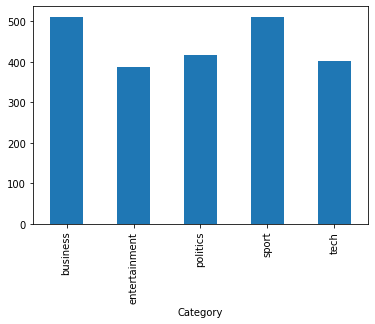

In [ ]:
root_path="/content/drive/MyDrive/bbc/" # Root path for the bbc articles
csv_path="/content/bbc_csv/" # The path where to create csv file of each category
num_folds = 5 # Cross Validition number of folds

df,id_to_category=loading_and_transforming_dataset(root_path,csv_path)


##Split Dataset

In [ ]:
X_train,X_test,y_train,y_test=split_dataset(df)

Data divided into features (X) and target (y)..... Done
Dataset splited into  train (80%) and test (20%) set..... Done


##Text Preprocessing

In [ ]:
X_train,X_test=data_preprocessing(X_train,X_test)

Text preprocessing .... Done


##Training

In [ ]:
''' list of different features extraction and selection to training the Support vector machine model. 
    Each element in the list represent an experiment on feature selection and extraction.
    [(classifier name, classifier, features extraction, ngram range, percentage of selected features)] 
'''

models = [ ('SVM', SVC(),'Count Vectors',(1,1),10)
          ,   ('SVM', SVC(),'TF-IDF Vectors',(1,1),10)
          ,   ('SVM', SVC(),'TF-IDF Vectors',(2,3),10)
          ,('SVM', SVC(),'Count Vectors',(1,1),30)
          ,   ('SVM', SVC(),'TF-IDF Vectors',(1,1),30)
          ,   ('SVM', SVC(),'TF-IDF Vectors',(2,3),30)   
          ,('SVM', SVC(),'Count Vectors',(1,1),50)
          ,   ('SVM', SVC(),'TF-IDF Vectors',(1,1),50)
          ,   ('SVM', SVC(),'TF-IDF Vectors',(2,3),50)
          ]


###Training without tuning

In [ ]:
training_evaluation = pd.DataFrame(columns = ["Model/Featuers", "Average Accuracy","Average Precision","Average Recall","Average F1"])
model_to_tuning=[]#list of model to use in traing with tuning
print("Trining ....... Start")
print("Number of flods specified ... ",num_folds,"\n")
from sklearn.feature_selection import SelectPercentile, chi2
for (model_name, model,feature,gram,featuer_per) in models: # train all the exparments we have in the list
    model= models_on_folds(model, model_name,feature ,num_folds,X_train,y_train,gram,featuer_per)
    model_to_tuning.append(model)
    df_length = len(training_evaluation)
    training_evaluation.loc[df_length] = model[3:]
print("Trining ....... End")
training_evaluation

Trining ....... Start
Number of flods specified ...  5 

Trining ....... End


,Model/Featuers,Average Accuracy,Average Precision,Average Recall,Average F1
0,"SVM Count Vectors N-Gram (1, 1)10 %",0.955,0.956,0.954,0.954
1,"SVM TF-IDF Vectors N-Gram (1, 1)10 %",0.976,0.976,0.977,0.976
2,"SVM TF-IDF Vectors N-Gram (2, 3)10 %",0.856,0.878,0.852,0.859
3,"SVM Count Vectors N-Gram (1, 1)30 %",0.958,0.959,0.958,0.958
4,"SVM TF-IDF Vectors N-Gram (1, 1)30 %",0.978,0.978,0.978,0.978
5,"SVM TF-IDF Vectors N-Gram (2, 3)30 %",0.902,0.913,0.900,0.904
6,"SVM Count Vectors N-Gram (1, 1)50 %",0.954,0.954,0.954,0.953
7,"SVM TF-IDF Vectors N-Gram (1, 1)50 %",0.976,0.976,0.976,0.976
8,"SVM TF-IDF Vectors N-Gram (2, 3)50 %",0.919,0.928,0.917,0.920


###Training with tuning

In [ ]:
tuning_evaluation = pd.DataFrame(columns = ["Model/Featuers","Best parameters", "Average Accuracy","Average Precision","Average Recall","Average F1"])
model_to_test=[]#list of model to use in testin 
print("Training with tuning.... Start")
print("Number of flods specified ... ",num_folds,"\n")
for model in model_to_tuning: # train all trained model with tuning
  tuning=trainin_tuning(model,X_train,y_train,num_folds)
  model_to_test.append(tuning)
  df_length = len(tuning_evaluation)
  tuning_evaluation.loc[df_length] = tuning[3:]
print("Training with tuning.... End")
tuning_evaluation

Training with tuning.... Start
Number of flods specified ...  5 

Training with tuning.... End


,Model/Featuers,Best parameters,Average Accuracy,Average Precision,Average Recall,Average F1
0,"SVM Count Vectors N-Gram (1, 1)10 %",C: 1 gamma: auto kernel: rbf,0.962,0.963,0.962,0.962
1,"SVM TF-IDF Vectors N-Gram (1, 1)10 %",C: 5 gamma: scale kernel: rbf,0.976,0.976,0.976,0.976
2,"SVM TF-IDF Vectors N-Gram (2, 3)10 %",C: 1 gamma: scale kernel: rbf,0.883,0.902,0.879,0.886
3,"SVM Count Vectors N-Gram (1, 1)30 %",C: 5 gamma: auto kernel: rbf,0.968,0.968,0.968,0.968
4,"SVM TF-IDF Vectors N-Gram (1, 1)30 %",C: 1 gamma: scale kernel: linear,0.982,0.982,0.982,0.982
5,"SVM TF-IDF Vectors N-Gram (2, 3)30 %",C: 1 gamma: scale kernel: rbf,0.930,0.937,0.928,0.931
6,"SVM Count Vectors N-Gram (1, 1)50 %",C: 5 gamma: auto kernel: rbf,0.966,0.966,0.966,0.966
7,"SVM TF-IDF Vectors N-Gram (1, 1)50 %",C: 5 gamma: scale kernel: rbf,0.982,0.982,0.982,0.982
8,"SVM TF-IDF Vectors N-Gram (2, 3)50 %",C: 1 gamma: scale kernel: rbf,0.941,0.946,0.939,0.942


##Testing

In [ ]:
model_to_deploye=[]
testing_evaluation = pd.DataFrame(columns = ["Model/Featuers", "Accuracy","Precision","Recall","F1"])
print("Testing .... Start")

for mod in model_to_test: # test all trained model
    model= test_model(mod,X_test,y_test)
    model_to_deploye.append(model)
    df_length = len(testing_evaluation)
    testing_evaluation.loc[df_length] = model[3:]
print("Testing .... End")

testing_evaluation

Testing .... Start
Testing .... End


,Model/Featuers,Accuracy,Precision,Recall,F1
0,"SVM Count Vectors N-Gram (1, 1)10 %",0.955,0.955,0.949,0.951
1,"SVM TF-IDF Vectors N-Gram (1, 1)10 %",0.978,0.976,0.977,0.976
2,"SVM TF-IDF Vectors N-Gram (2, 3)10 %",0.879,0.894,0.871,0.878
3,"SVM Count Vectors N-Gram (1, 1)30 %",0.966,0.967,0.962,0.964
4,"SVM TF-IDF Vectors N-Gram (1, 1)30 %",0.975,0.975,0.972,0.974
5,"SVM TF-IDF Vectors N-Gram (2, 3)30 %",0.921,0.935,0.914,0.920
6,"SVM Count Vectors N-Gram (1, 1)50 %",0.966,0.967,0.962,0.964
7,"SVM TF-IDF Vectors N-Gram (1, 1)50 %",0.987,0.986,0.984,0.985
8,"SVM TF-IDF Vectors N-Gram (2, 3)50 %",0.926,0.933,0.921,0.925


Use The best perfomed one => SVM TF-IDF Vectors N-Gram (1, 1) featuer selection 50 %


---
In this section, we tested the selected model with random News from the Internet. And the result was as expected.
Where the first article should be politics and the second article should be a sport.

In [ ]:
svm_clf = model_to_deploye[7][0]
fetuers_vectorizer = model_to_deploye[7][1]
fetuers_selection = model_to_deploye[7][2]
new_string = ["Sir Keir Starmer has hailed Paulette Hamilton's victory in the Birmingham Erdington by-election as the passing of a baton from one great champion of working people to another. The former nurse polled 9,413 votes, 55% of ballots cast, as Labour increased its vote share.She has become Birmingham's first black MP and revealed her father died just as her campaign started.The by-election was held following the sudden death of Jack Dromey.The veteran MP died in January aged 73 and had held the seat since 2010.",
              "he Russian Football Union said it will go to the Court of Arbitration for Sport (Cas) to appeal against its ban from international competitions after the country's invasion of Ukraine.On Monday, Russian football clubs and national teams were suspended from all competitions until further notice by Fifa and Uefa.The union said it would file one lawsuit against football's world and European governing bodies, demanding Russia's men's and women's national teams be allowed to compete.Russia wants its national teams reinstated to play their men's World Cup play-off matches next month and the women's team once again included in this summer's Euro 2022 competition in England."]

string=[]
for x in new_string:
  string.append(preprocessing(x))


string_vectorized = fetuers_vectorizer.transform(string)
news = fetuers_selection.transform(string_vectorized)
prd=svm_clf.predict(news)
for category,string_new in zip(prd,new_string):
   print(id_to_category[category],"=>",string_new)



politics => Sir Keir Starmer has hailed Paulette Hamilton's victory in the Birmingham Erdington by-election as the passing of a baton from one great champion of working people to another. The former nurse polled 9,413 votes, 55% of ballots cast, as Labour increased its vote share.She has become Birmingham's first black MP and revealed her father died just as her campaign started.The by-election was held following the sudden death of Jack Dromey.The veteran MP died in January aged 73 and had held the seat since 2010.
sport => he Russian Football Union said it will go to the Court of Arbitration for Sport (Cas) to appeal against its ban from international competitions after the country's invasion of Ukraine.On Monday, Russian football clubs and national teams were suspended from all competitions until further notice by Fifa and Uefa.The union said it would file one lawsuit against football's world and European governing bodies, demanding Russia's men's and women's national teams be allow